In [2]:
cd modules

/home/dadmaan/Documents/dev/py_music/genre_classifier/modules


In [3]:
import os
import datetime

import utils
from genre_classifier_m2 import DNNModel
from IPython.display import Audio

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelBinarizer

# %load_ext tensorboard
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [4]:
# Dataset
DIR = '/run/media/dadmaan/Seagate Backup Plus Drive/datasets/'
AUDIO = os.path.join(DIR, 'fma/fma_small')
METADATA = os.path.join(DIR, 'fma/fma_metadata')

# Training
DS_TRAIN = 6400
DS_VALID = 800
DS_TEST = 800

EPOCHS = 20
BATCH_SIZE = 128
SHUFFLE_SIZE = 2 * BATCH_SIZE
STEPS_TRAIN = DS_TRAIN / BATCH_SIZE
STEPS_VALID = DS_VALID / BATCH_SIZE
STEPS_TEST = DS_TEST / BATCH_SIZE

## Data-set Prepration

In [5]:
tracks = utils.load(os.path.join(METADATA, 'tracks.csv'))
features = utils.load(os.path.join(METADATA, 'features.csv'))
genres = utils.load(os.path.join(METADATA, 'genres.csv'))

small = tracks['set', 'subset'] <= 'small'
train = tracks['set', 'split'] == 'training'
valid = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'

y_train = LabelBinarizer().fit_transform(tracks.loc[small & train, ('track', 'genre_top')])
y_train = pd.DataFrame(y_train, index=tracks.loc[small & train, ('track', 'genre_top')].index)
y_valid = LabelBinarizer().fit_transform(tracks.loc[small & valid, ('track', 'genre_top')])
y_valid = pd.DataFrame(y_valid , index=tracks.loc[small & valid, ('track', 'genre_top')].index)
y_test = LabelBinarizer().fit_transform(tracks.loc[small & test, ('track', 'genre_top')])
y_test = pd.DataFrame(y_test , index=tracks.loc[small & test, ('track', 'genre_top')].index)

X_train = features.loc[small & train, ('mfcc','mean')]
X_valid = features.loc[small & valid, ('mfcc','mean')]
X_test = features.loc[small & test, ('mfcc','mean')]

print('{} features, {} classes'.format(X_train.shape[1], y_train.shape[1]))

20 features, 8 classes


In [6]:
train_data = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
valid_data = tf.data.Dataset.from_tensor_slices((X_valid.values, y_valid.values))
test_data = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values))

In [7]:
train_data = (train_data.shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE).repeat())

valid_data = (valid_data.shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE).repeat())

test_data = (test_data.shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE).repeat(1))

## Model Prepration

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20)                80        
_________________________________________________________________
fc1 (Dense)                  (None, 1024)              21504     
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
fc2 (Dense)                  (None, 2048)              2099200   
_________________________________________________________________
fc3 (Dense)                  (None, 1024)              2098176   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0     

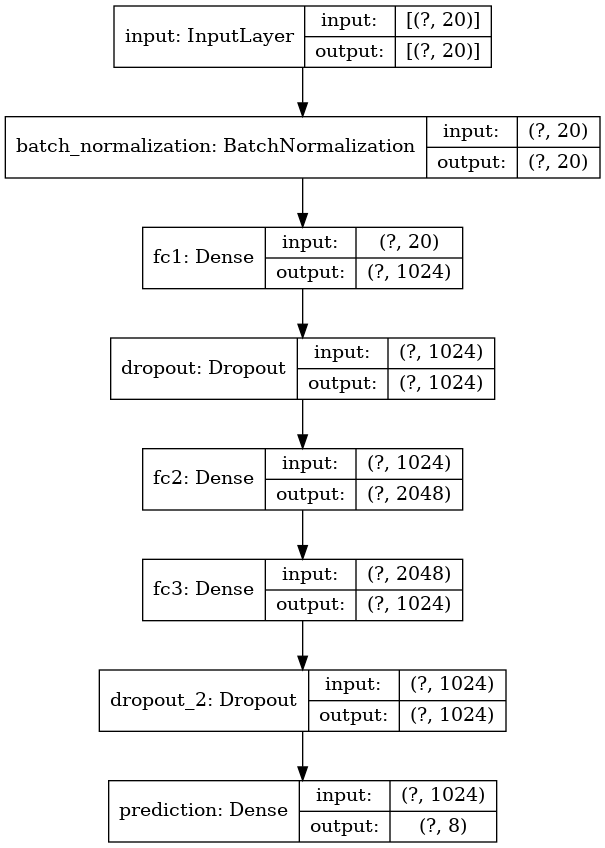

In [8]:
model = DNNModel()

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()
tf.keras.utils.plot_model(model, to_file='../visualization/genre_classifier_m2.png', 
                          show_shapes=True, 
                          show_layer_names=True)

## Load Weights

In [8]:
model.load_weights('../weights/exp1_gc_weights.hdf5', by_name=False)

## Train Model

In [9]:
filepath = "../weights/exp2_gc_improvement_{epoch:02d}_{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(
    filepath,
    monitor='loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
    mode='min'
)

# log_dir = "logs" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard = tf.keras.callbacks.TensorBoard(
#     log_dir='log_dir', histogram_freq=1, write_graph=True, write_images=True,
#     update_freq='epoch', profile_batch=2, embeddings_freq=0,
#     embeddings_metadata=None
# )

callbacks_list = [checkpoint]

In [10]:
history = model.fit(train_data, 
                    epochs=EPOCHS, 
                    steps_per_epoch=STEPS_TRAIN,
                    validation_data=valid_data,
                    validation_steps=STEPS_VALID,
                    callbacks=callbacks_list)
print('\n\nHistory dict :',history.history, file=open('../metrics/exp2_gc_log.txt', 'a'))

Train for 50.0 steps, validate for 6.25 steps
Epoch 1/20
50/50 [==============================] - 8s 164ms/step - loss: 1.7486 - accuracy: 0.3483 - val_loss: 2.8875 - val_accuracy: 0.2537
Epoch 2/20
50/50 [==============================] - 7s 146ms/step - loss: 1.6574 - accuracy: 0.3920 - val_loss: 2.4461 - val_accuracy: 0.2775
Epoch 3/20
50/50 [==============================] - 7s 149ms/step - loss: 1.6100 - accuracy: 0.4220 - val_loss: 2.2185 - val_accuracy: 0.3113
Epoch 4/20
50/50 [==============================] - 8s 150ms/step - loss: 1.5749 - accuracy: 0.4311 - val_loss: 2.0052 - val_accuracy: 0.3525
Epoch 5/20
50/50 [==============================] - 7s 148ms/step - loss: 1.5370 - accuracy: 0.4395 - val_loss: 2.0170 - val_accuracy: 0.3550
Epoch 6/20
50/50 [==============================] - 8s 151ms/step - loss: 1.5178 - accuracy: 0.4461 - val_loss: 1.8846 - val_accuracy: 0.3762
Epoch 7/20
50/50 [==============================] - 8s 159ms/step - loss: 1.4689 - accuracy: 0.4638 - 

In [11]:
model.save_weights('../weights/exp2_gc_weights.hdf5')

## Plot Training Results

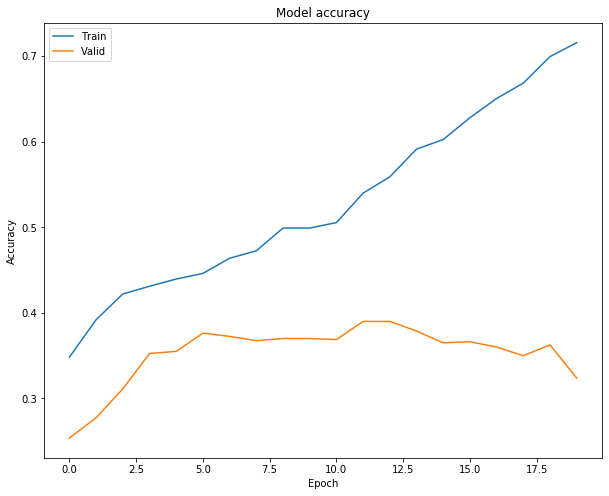

In [12]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.savefig('../metrics/exp1_gc_model_accuracy.png')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.savefig('../metrics/exp1_gc_model_loss.png')
plt.show()

## Evaluate Model

In [13]:
results = model.evaluate(test_data, steps=STEPS_TEST)
print('\ntest loss, test acc:', results, file=open('../metrics/exp2_ic_log.txt', 'a'))

7/6 [=================================] - 1s 72ms/step - loss: 2.6752 - accuracy: 0.3038


## Predictions

In [14]:
predictions = model.predict(test_data)

In [15]:
columns = genres.reset_index().set_index('title')
columns = columns.loc[tracks.loc[small, ('track', 'genre_top')].unique()]

In [16]:
pred = pd.DataFrame(data=predictions[0:, 0:],
            columns=columns.index.values)
pred.to_csv('../metrics/exp2_predictions.csv', index=False)

In [17]:
pred > 0.5

Hip-Hop    Pop   Folk  Experimental   Rock  International  Electronic  \
0      False  False   True         False  False          False       False   
1      False  False  False         False  False          False       False   
2      False  False  False         False  False          False       False   
3      False  False  False         False  False          False        True   
4      False  False  False         False  False          False       False   
..       ...    ...    ...           ...    ...            ...         ...   
795    False   True  False         False  False          False       False   
796    False  False   True         False  False          False       False   
797    False  False  False         False  False          False       False   
798    False  False  False         False  False          False       False   
799    False  False  False         False  False          False       False   

     Instrumental  
0           False  
1           False  
2           False  
3           False  
4           False  
..            ...  
795         False  
796         False  
797         False  
798         False  
799         False  

[800 rows x 8 columns]